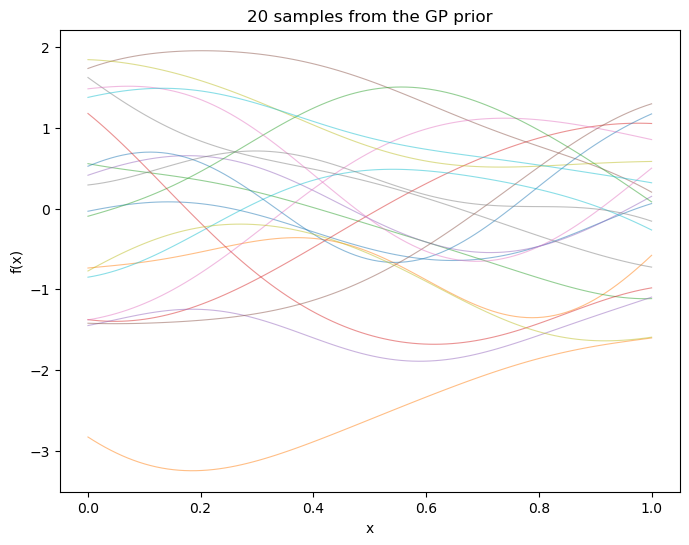

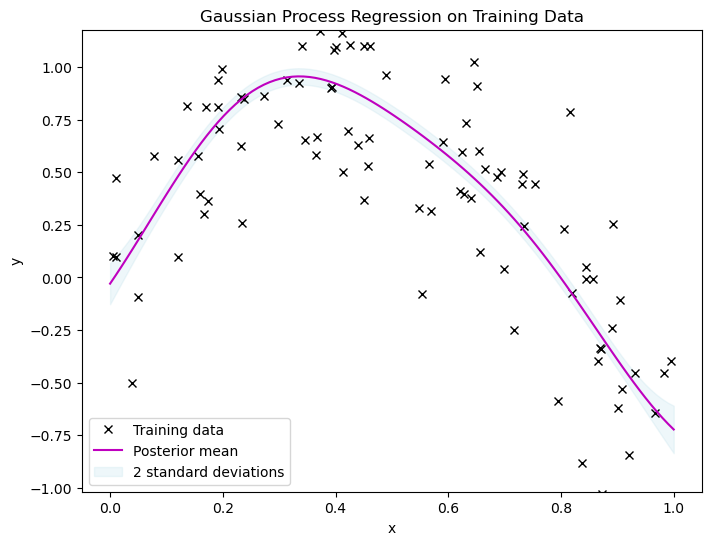

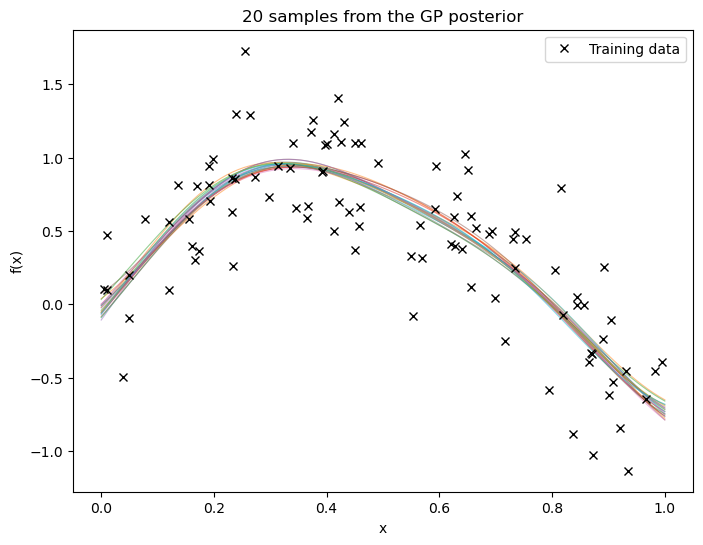

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def rbf_kernel(x1, x2, tau= np.sqrt(0.12)):
    '''
    Calculates the Gaussian Radial Basis Function (RBF) kernel between points.
    '''
    return np.exp(-((x1 - x2) ** 2) / (2 * tau ** 2))


def generate_samples(N, kernel, num_samples):
    '''
    Generates samples from a Gaussian Process with a specified kernel.
    '''
    x = np.linspace(0, 1, N) # Equally spaced points in [0, 1]
    K = kernel(x.reshape(-1, 1), x.reshape(1, -1))
    # Drawing samples from the GP prior
    samples = np.random.multivariate_normal(np.zeros(N), K, size=num_samples)
    return x, samples

def plot_samples(x, samples, title, x_train=None, y_train=None):
    '''
    Plots the samples from a Gaussian Process.
    '''
    plt.figure(figsize=(8, 6))
    for sample in samples:
        plt.plot(x, sample, '-', alpha=0.5, linewidth=0.8)
    if x_train is not None and y_train is not None:
        plt.plot(x_train, y_train, 'kx', label='Training data')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(title)
    if x_train is not None and y_train is not None:
        plt.legend()
    plt.show()

def load_data(filename):
    '''
    Load the training data from the file.
    '''
    data = np.loadtxt(filename)
    return data[:, 0], data[:, 1]

def compute_posterior(x_train, y_train, x_test, kernel, sigma_n=0.1):
    '''
    Computes the posterior mean and covariance for GP regression.
    '''
    K_train = kernel(x_train.reshape(-1, 1), x_train.reshape(1, -1))
    K_inv = np.linalg.inv(K_train + sigma_n**2 * np.eye(len(x_train)))
    
    post_mean = np.zeros(len(x_test))
    post_cov = np.zeros((len(x_test), len(x_test)))
    
    for i in range(len(x_test)):
        k_test_i = kernel(x_test[i], x_train)
        post_mean[i] = k_test_i @ K_inv @ y_train
        
        for j in range(len(x_test)):
            k_test_j = kernel(x_test[j], x_train)
            post_cov[i, j] = kernel(x_test[i], x_test[j]) - k_test_i @ K_inv @ k_test_j.T
    
    return post_mean, post_cov

def plot_posterior(x_train, y_train, x_test, post_mean, post_std):
    '''
    Plots the posterior mean and confidence intervals of the GP regression.
    '''
    plt.figure(figsize=(8, 6))
    plt.plot(x_train, y_train, 'kx', label='Training data')
    plt.plot(x_test, post_mean, 'm-', label='Posterior mean')
    plt.fill_between(x_test, post_mean - 2*post_std, post_mean + 2*post_std,
                     color='lightblue', alpha=0.2, label='2 standard deviations')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression on Training Data')
    plt.legend()
    
    y_min = np.min(post_mean - 2*post_std)
    y_max = np.max(post_mean + 2*post_std)
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
    plt.show()

# Number of points to plot 
N = 100
# Generate prior samples using the RBF kernel
x, prior_samples = generate_samples(N, rbf_kernel, num_samples=20)
# Plot the generated samples from the GP prior
plot_samples(x, prior_samples, '20 samples from the GP prior')


x_train, y_train = load_data('gp.dat')
x_test = np.linspace(0, 1, N)
# Compute the posterior mean and covariance matrix based on the training data and RBF kernel
post_mean, post_cov = compute_posterior(x_train, y_train, x_test, rbf_kernel)
# Calculate the standard deviation for the posterior distribution
post_std = np.sqrt(np.diag(post_cov))

# Plot the posterior mean and the two standard deviation bounds around it
plot_posterior(x_train, y_train, x_test, post_mean, post_std)

# Draw 20 samples from the posterior distribution
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
# Plot the 20 samples from the posterior distribution along with the training data
plot_samples(x_test, post_samples, '20 samples from the GP posterior', x_train, y_train)
